# Importing Libraries

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2022-12-20 23:52:24.498395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data/.DS_Store
Data/Training/.DS_Store
Data/Training/no_tumor/image(115).jpg
Data/Training/no_tumor/image(142).jpg
Data/Training/no_tumor/image(49).jpg
Data/Training/no_tumor/image(1).jpg
Data/Training/no_tumor/image(284).jpg
Data/Training/no_tumor/image(154).jpg
Data/Training/no_tumor/image(292).jpg
Data/Training/no_tumor/image(103).jpg
Data/Training/no_tumor/image(197).jpg
Data/Training/no_tumor/image(178).jpg
Data/Training/no_tumor/image(73).jpg
Data/Training/no_tumor/image(251).jpg
Data/Training/no_tumor/image(314).jpg
Data/Training/no_tumor/image(24).jpg
Data/Training/no_tumor/image (26).jpg
Data/Training/no_tumor/image(206).jpg
Data/Training/no_tumor/image (5).jpg
Data/Training/no_tumor/image(139).jpg
Data/Training/no_tumor/image(32).jpg
Data/Training/no_tumor/image(210).jpg
Data/Training/no_tumor/image (30).jpg
Data/Training/no_tumor/image(181).jpg
Data/Training/no_tumor/image(65).jpg
Data/Training/no_tumor/image(247).jpg
Data/Training/no_tumor/image(302).jpg
Data/Training/no_tu

---

# Color

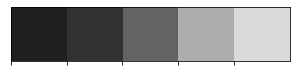

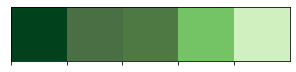

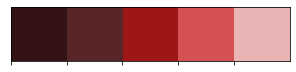

In [12]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [13]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [21]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('Data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:03<00:00, 24.02it/s]


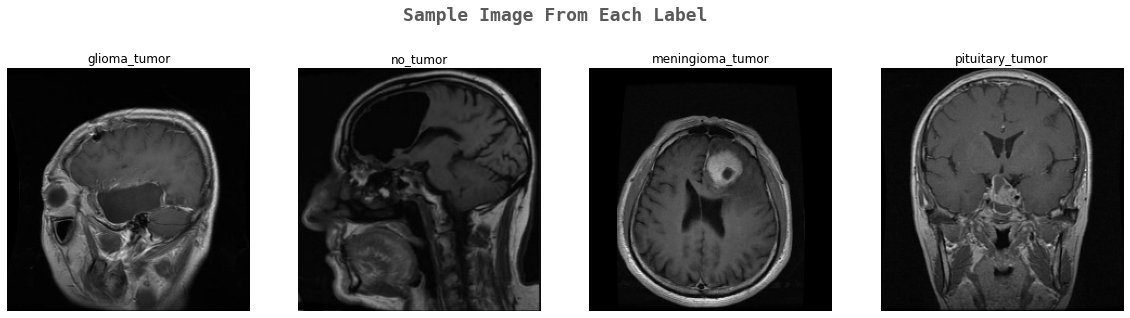

In [22]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [23]:
X_train, y_train = shuffle(X_train,y_train, random_state=152)

In [24]:
X_train.shape

(3264, 224, 224, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=156)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [26]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

### GoogLeNet

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = Concatenate(axis = -1)([path1, path2, path3, path4])

    return output_layer

In [28]:
def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(4, activation = 'softmax')(X)

    # model
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [29]:
tensorboard_GGN = TensorBoard(log_dir = 'logs')
checkpoint_GGN = ModelCheckpoint("ggnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
# reduce_lr_GGN = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
#                               mode='auto',verbose=1)
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

---

# Training The Model

In [30]:
model_GGN = GoogLeNet()
model_GGN.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model_GGN.fit(X_train,y_train,validation_split=0.1, epochs = 20, verbose=1, batch_size=30,
              callbacks=[tensorboard_GGN,checkpoint_GGN])

2022-12-21 00:02:47.175680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
79/79 [==============================] - ETA: 0s - loss: 1.3833 - accuracy: 0.3252
Epoch 1: val_accuracy improved from -inf to 0.33588, saving model to ggnet.h5
79/79 [==============================] - 188s 2s/step - loss: 1.3833 - accuracy: 0.3252 - val_loss: 1.3023 - val_accuracy: 0.3359
Epoch 2/20
79/79 [==============================] - ETA: 0s - loss: 1.2071 - accuracy: 0.4491
Epoch 2: val_accuracy improved from 0.33588 to 0.54198, saving model to ggnet.h5
79/79 [==============================] - 176s 2s/step - loss: 1.2071 - accuracy: 0.4491 - val_loss: 1.0671 - val_accuracy: 0.5420
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 0.9708 - accuracy: 0.5939
Epoch 3: val_accuracy improved from 0.54198 to 0.60305, saving model to ggnet.h5
79/79 [==============================] - 173s 2s/step - loss: 0.9708 - accuracy: 0.5939 - val_loss: 0.8754 - val_accuracy: 0.6031
Epoch 4/20
79/79 [==============================] - ETA: 0s - loss: 0.8552 - accuracy: 0

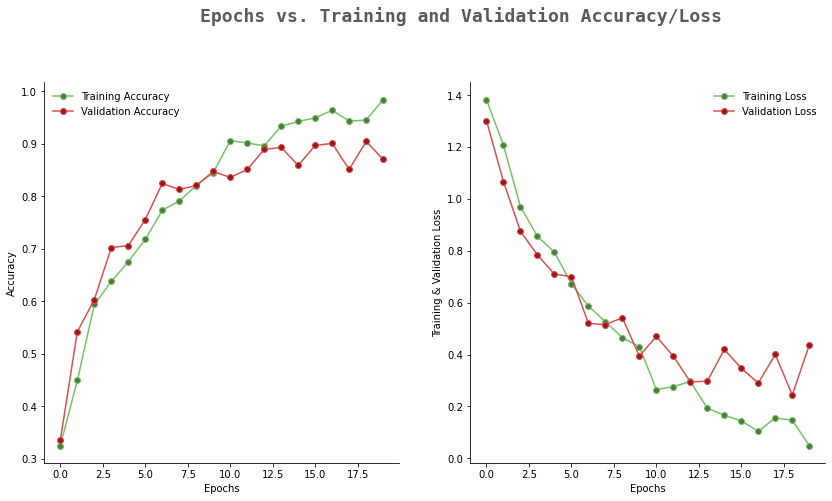

In [31]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [32]:
pred = model_GGN.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 13s 547ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [33]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       188
           1       0.95      0.81      0.87       107
           2       0.86      0.93      0.89       208
           3       0.99      0.93      0.96       150

    accuracy                           0.90       653
   macro avg       0.92      0.89      0.90       653
weighted avg       0.91      0.90      0.90       653



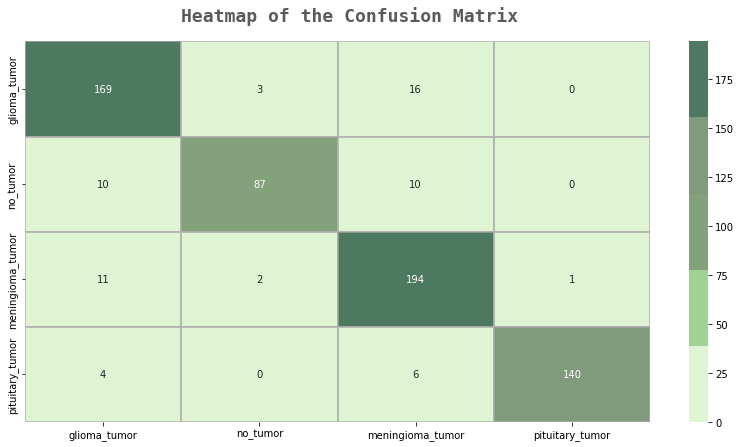

In [34]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3],fmt='d')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()